# **Generate** the analysis-ready BGC-Argo float time series

### <span style="color:red">--- User input begins ---</span>
- `wmoid`: the float's WMO
- `qc2keep`: value(s) of QC flags to be considered valid (\['1','2','5','8'\] is a standard choice, but modify as necessary) 

In [1]:
wmoid = 6903574
qc2keep = ['1','2','5','8']

### <span style="color:red">--- User input ends ---</span>

## 1. Read raw profiles (1234567_Sprof.nc)

### Load modules

In [2]:
import xarray as xr
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import generic_filter
import pvlib
import gsw
import scipy
import datetime

### Load input file

In [3]:
in_file = str(wmoid)+"/"+str(wmoid)+"_Sprof.nc"
ds = xr.open_dataset(in_file) 
ds

<xarray.Dataset> Size: 316MB
Dimensions:                            (N_PROF: 287, N_PARAM: 14, N_CALIB: 1,
                                        N_LEVELS: 2481)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/128)
    DATA_TYPE                          object 8B ...
    FORMAT_VERSION                     object 8B ...
    HANDBOOK_VERSION                   object 8B ...
    REFERENCE_DATE_TIME                object 8B ...
    DATE_CREATION                      object 8B ...
    DATE_UPDATE                        object 8B ...
    ...                                 ...
    NITRATE                            (N_PROF, N_LEVELS) float32 3MB ...
    NITRATE_QC                         (N_PROF, N_LEVELS) object 6MB ...
    NITRATE_dPRES                      (N_PROF, N_LEVELS) float32 3MB ...
    NITRATE_ADJUSTED                   (N_PROF, N_LEVELS) float32 3MB ...
    NITRATE_ADJUSTED_QC                (N_PROF, N_LEVELS) object 6MB ...
    NITRATE_ADJUSTED_ERROR             (N_PROF, N_LEVELS) float32 3MB ...
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2024-12-24T14:16:54Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

### Read all profiles

In [4]:
# standard variable names
vars_original = ['TEMP_ADJUSTED',
                 'PSAL_ADJUSTED',
                 'DOWNWELLING_PAR_ADJUSTED',
                 'NITRATE_ADJUSTED',
                 'CHLA_ADJUSTED',
                 'BBP700_ADJUSTED',
                 'DOXY_ADJUSTED',
                 'PH_IN_SITU_TOTAL_ADJUSTED',
                ]

def calc_solar_elevation_vectorized(latitude, longitude, times):
    """
    Calculates solar elevation in a fully vectorized way.
    Inputs must be array-like (lists, np.array, pd.Series)
    of matching lengths.
    
    Args:
        latitude (array-like): Latitudes
        longitude (array-like): Longitudes
        times (pd.DatetimeIndex or array-like): Timezone-aware datetimes
    """
    
    # This function handles the element-wise calculation
    solar_position = pvlib.solarposition.get_solarposition(
        times, 
        latitude, 
        longitude
    )
    
    solar_elevation = 90 - solar_position['zenith'].values
    
    # This returns a pandas Series (or a numpy array 
    # if you pass numpy arrays as input)
    return solar_elevation

# Determine whether to use PRES or PRES_ADJUSTED
# use PRES if all values are NaN for PRES_ADJUSTED
if np.isnan(ds['PRES_ADJUSTED'].values).all():
    name_pres = "PRES"
# use PRES_ADJUSTED if non-NaN values exist
else:
    name_pres = "PRES_ADJUSTED"

# Function to filter the data based on QC flag values
# Two xarrays are returned: the values and the depths
def ds_valid(name_in,qc_valid):
    qc_mask = ds[name_in+"_QC"].astype(str).isin(qc_valid)
    return ds[name_in].where(qc_mask,other=np.nan),ds[name_pres].where(qc_mask,other=np.nan)

# daytime_valid is boolean for daytime profiles; 
# mask_qc5 is boolean for CHLA_ADJUSTED with at least 1 data with QC = 5 for each profile
if "CHLA_ADJUSTED" in ds.data_vars and ds_valid("CHLA_ADJUSTED",qc2keep)[0].notnull().any():
    daytime_valid = calc_solar_elevation_vectorized(ds['LATITUDE'].values,ds['LONGITUDE'].values,ds['JULD'].values) > 0 # True if sun is above horizon (daytime)
    ds_chla_qc5 = ds_valid("CHLA_ADJUSTED","5")[0]
    mask_qc5 = ds_chla_qc5.notnull().any(dim="N_LEVELS").values

### Visualize the sampling frequency in time (time difference between consecutive profiles)

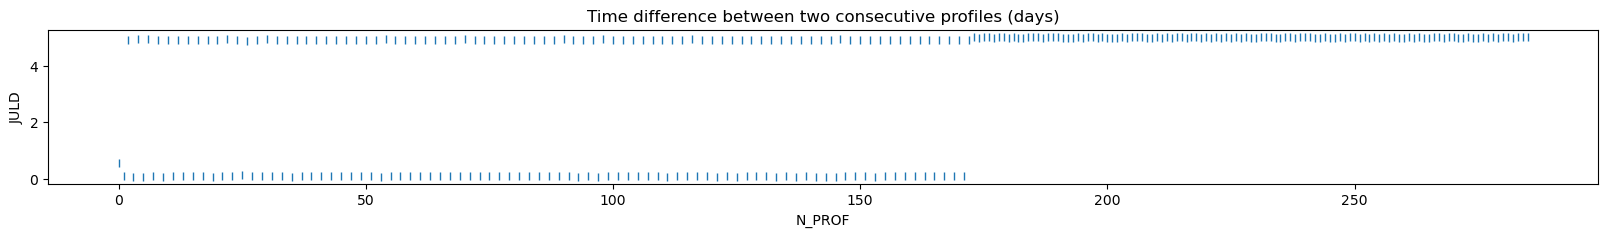

In [5]:
plt.figure(figsize=(20,2))
spacing_days = ds["JULD"].diff(dim="N_PROF") / np.timedelta64(1, 'D')
spacing_days.plot(marker="|",ls="None")
plt.title('Time difference between two consecutive profiles (days)')
plt.show()
plt.close()

### Visualize the raw data to understand the spatial and temporal coverage of the data
- "NO DATA" means the variable does not exist.
- "NO VALID DATA" means the variable exits but all values are NaNs.

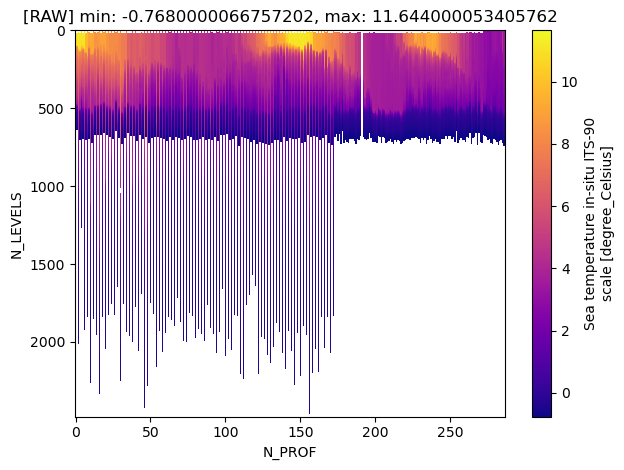

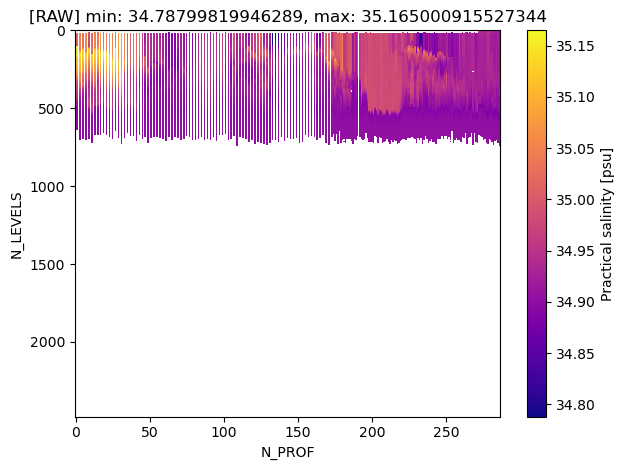

NO VALID DATA for DOWNWELLING_PAR_ADJUSTED


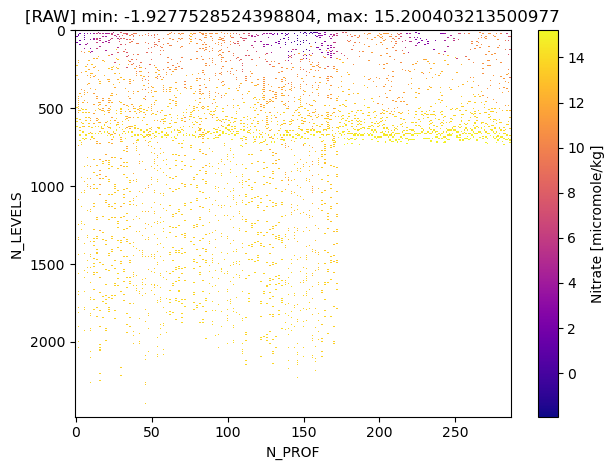

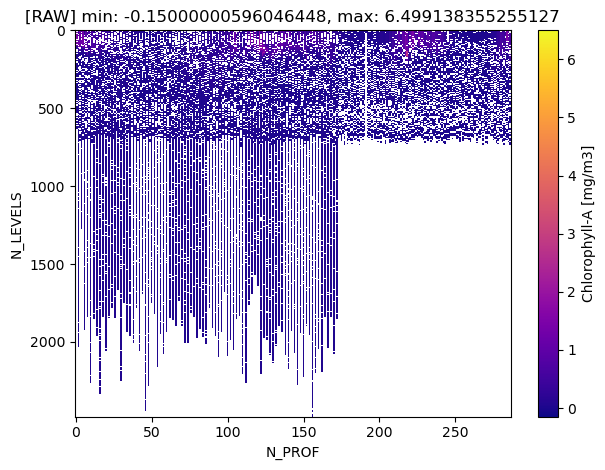

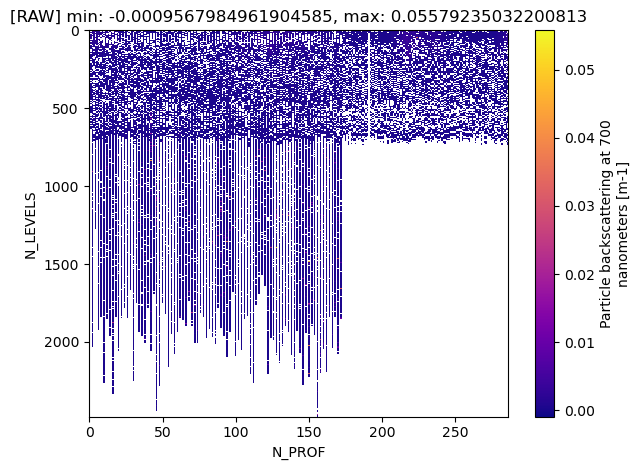

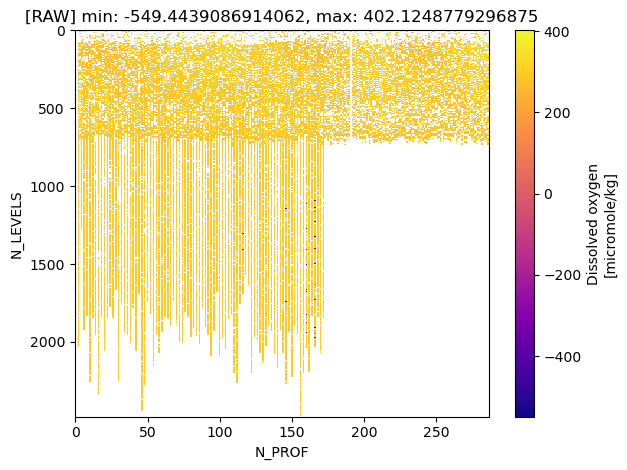

NO VALID DATA for PH_IN_SITU_TOTAL_ADJUSTED


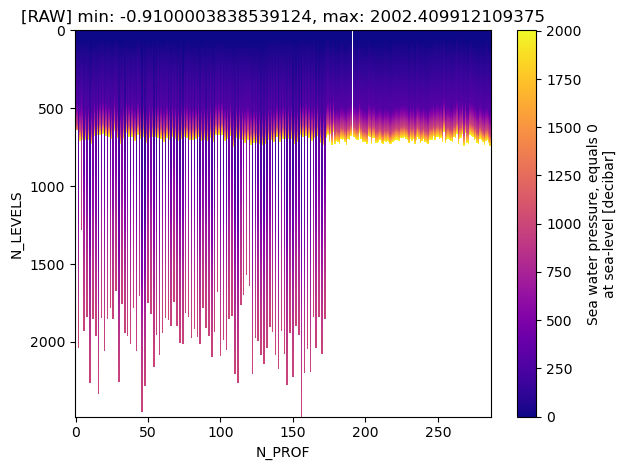

In [6]:
for j in range(len(vars_original)): # loop over variables
    try:
        vars_original[j] in ds.data_vars
        if ds[vars_original[j]].notnull().any(): # if finite values exit
            fig = plt.figure()
            mmin,mmax = ds[vars_original[j]].min(),ds[vars_original[j]].max()
            ds[vars_original[j]].plot(x="N_PROF",cmap="plasma",vmin=mmin,vmax=mmax)
            plt.title("[RAW] min: "+str(mmin.values)+", max: "+str(mmax.values))            
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            plt.close(fig)
        else:
          print('NO VALID DATA for '+vars_original[j])  
    except:
        print('NO DATA for '+vars_original[j])
# PRESSURE
fig = plt.figure()
mmin,mmax = ds[name_pres].min(),ds[name_pres].max()
ds[name_pres].plot(x="N_PROF",cmap="plasma",vmin=mmin,vmax=mmax)
plt.title("[RAW] min: "+str(mmin.values)+", max: "+str(mmax.values))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
plt.close(fig)

## 2. Filter using QC values (default: 1,2,5,8)
- "NO GOOD DATA" means the variable exits but all values are NaNs before/after applying QC.
- QC flags for pressure data are not applied but displayed here for interest (1 or nan).

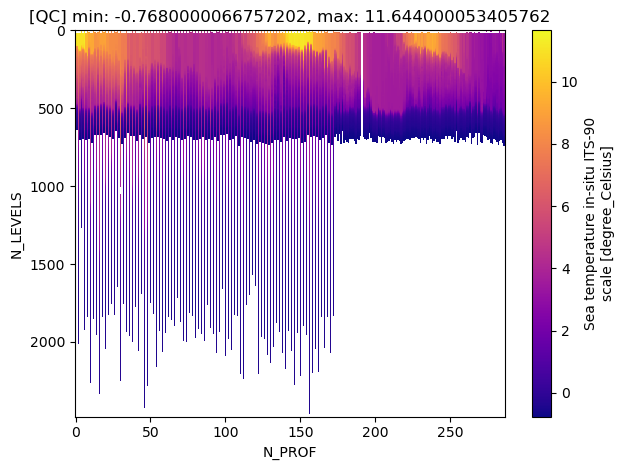

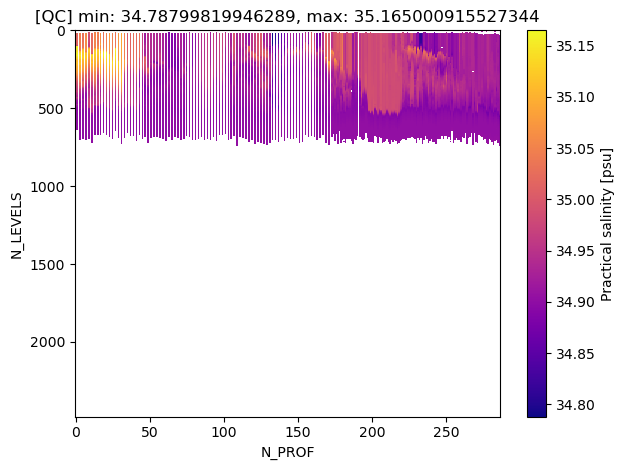

NO GOOD DATA for DOWNWELLING_PAR_ADJUSTED


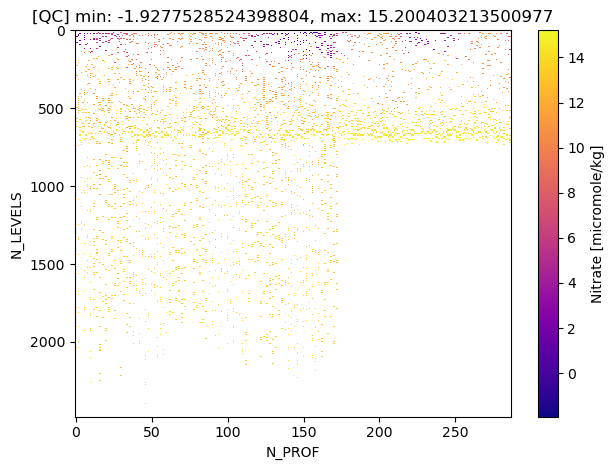

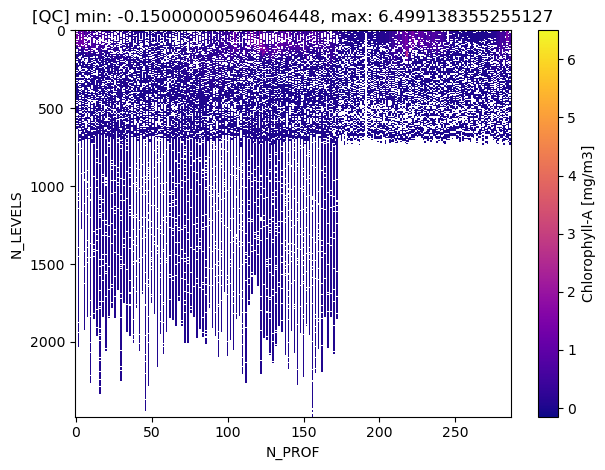

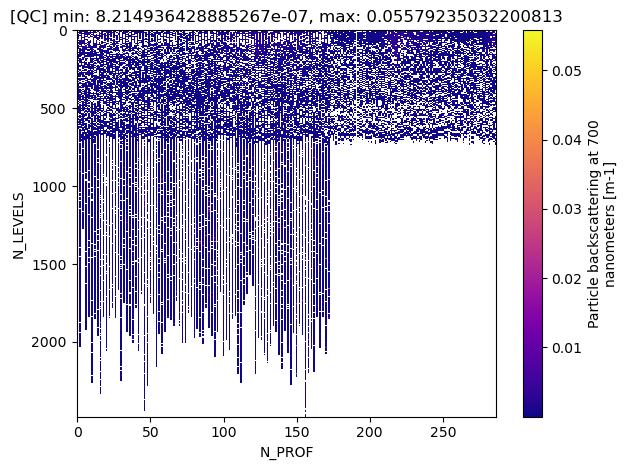

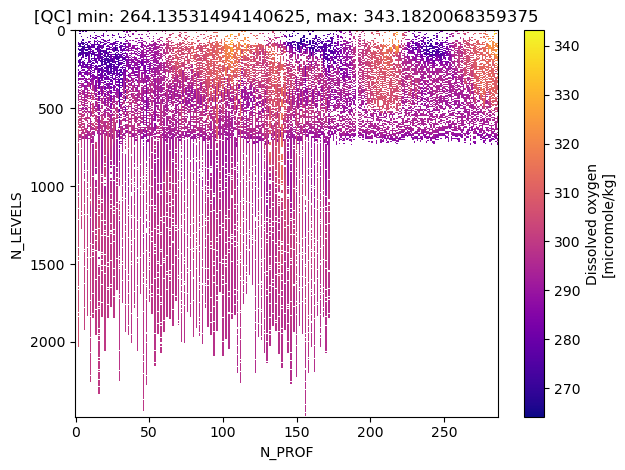

NO GOOD DATA for PH_IN_SITU_TOTAL_ADJUSTED


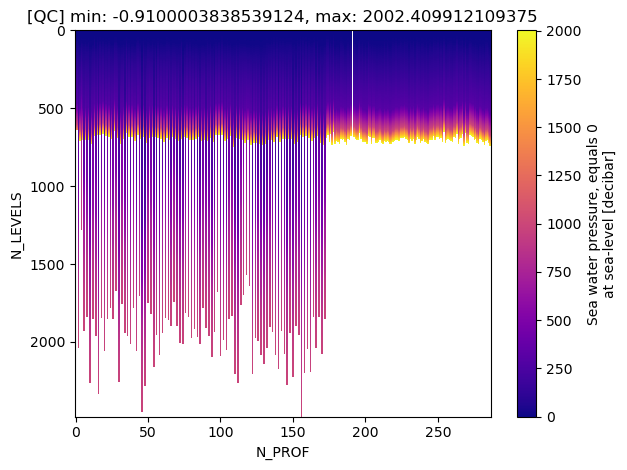

In [7]:
for j in range(len(vars_original)): # loop over variables
    try:
        good_ds,good_pres = ds_valid(vars_original[j],qc2keep)
        if good_ds.notnull().any(): # if finite values exit
            fig = plt.figure()
            mmin,mmax = good_ds.min(),good_ds.max()
            good_ds.plot(x="N_PROF",cmap="plasma",vmin=mmin,vmax=mmax)
            plt.title("[QC] min: "+str(mmin.values)+", max: "+str(mmax.values))
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            plt.close(fig)
        else:
            print('NO GOOD DATA for '+vars_original[j])
    except KeyError:
        print('NO DATA for '+vars_original[j])
# PRESSURE
good_ds,good_pres = ds_valid(name_pres,'1')
fig = plt.figure()
mmin,mmax = good_ds.min(),good_ds.max()
ds[name_pres].plot(x="N_PROF",cmap="plasma",vmin=mmin,vmax=mmax)
plt.title("[QC] min: "+str(mmin.values)+", max: "+str(mmax.values))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
plt.close(fig)

## 3. Smooth CHLA_ADJUSTED based on Schmechtig et al. (2023)

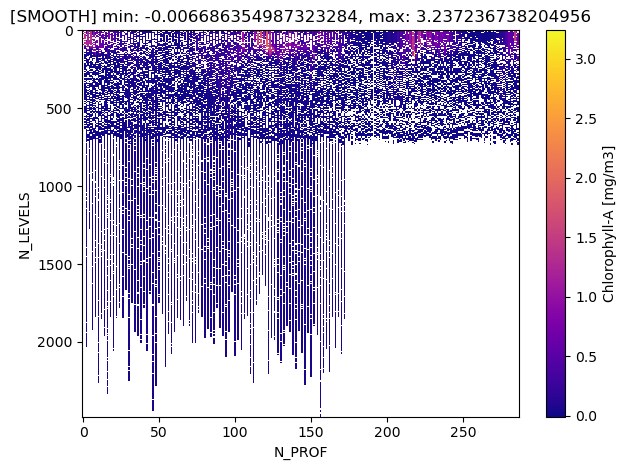

In [8]:
try:
    good_ds,good_pres = ds_valid("CHLA_ADJUSTED",qc2keep)
    if good_ds.notnull().any(): # if finite values exit
        # vertical resolution
        pres_res = good_pres.diff(dim="N_LEVELS")
        pres_res_med = pres_res.median(dim="N_LEVELS")
    
        # create a dataset for smoothed profile
        ds_smooth = good_ds
    
        # 1. Create a boolean mask of where valid data currently exists
        original_mask = ds_smooth.notnull()
        
        # loop over profiles
        for i in range(pres_res_med.size):
            # window size logic (same as yours)
            if pres_res_med[i] >= 3:
                nsmooth = 5
            elif pres_res_med[i] <= 1:
                nsmooth = 11
            else:
                nsmooth = 7
            
            # 2. Apply Smoothing
            # You can keep min_periods=1 here if you want robust smoothing...
            smoothed_profile = ds_smooth[i,:].rolling(N_LEVELS=nsmooth, center=True, min_periods=1).median()
            
            # 3. ...BUT immediately re-apply the original mask
            # This forces any index that was originally NaN to stay NaN
            ds_smooth[i,:] = smoothed_profile.where(original_mask[i,:])
    
        # Plot
        fig = plt.figure()
        mmin,mmax = ds_smooth.min(),ds_smooth.max()
        ds_smooth.plot(x="N_PROF",cmap="plasma",vmin=mmin,vmax=mmax)
        plt.title("[SMOOTH] min: "+str(mmin.values)+", max: "+str(mmax.values))
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        plt.close(fig)
    else:
        print('NO GOOD DATA for CHLA_ADJUSTED')
except KeyError:
    print('NO DATA for CHLA_ADJUSTED')   

## 4. Decompose BBP700_ADJUSTED based on Briggs et al. (2020)
- method based on Briggs et al. 2020 (page 3 of their SI), but simplified (simply 11-point min and max filters).

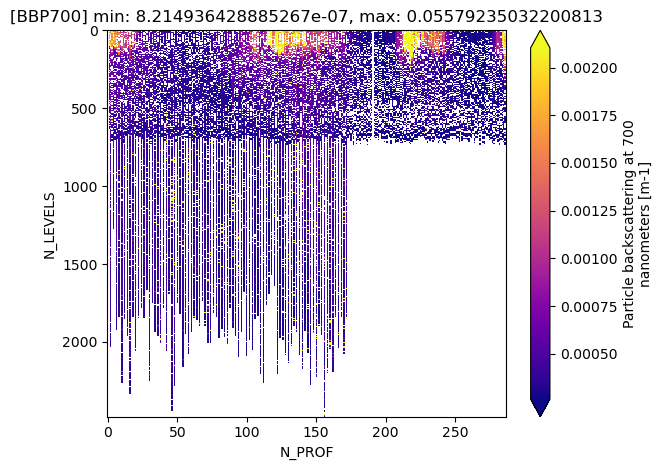

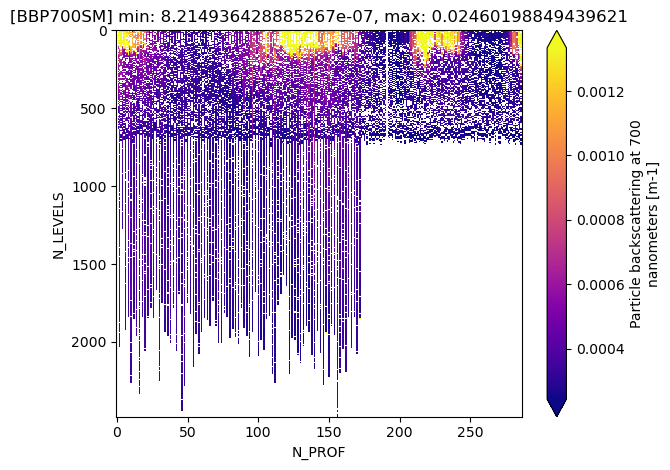

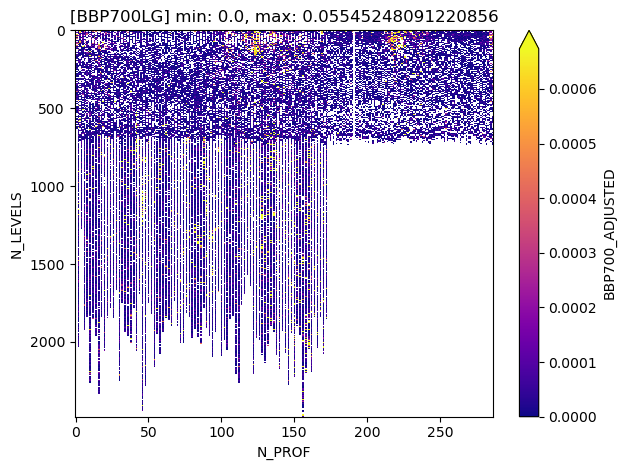

In [9]:
try:
    good_ds,good_pres = ds_valid("BBP700_ADJUSTED",qc2keep)
    if good_ds.notnull().any(): # if finite values exit

        # Get valid data
        ds_bbp = good_ds
        
        # --- METHOD 1: STRICT MASKING START ---
        
        # 1. Capture the original data footprint (Where is data valid?)
        original_mask = ds_bbp.notnull()
        
        # 2. Apply Minimum Filter
        # We keep min_periods=1 to handle edges robustly, knowing we will mask later
        min_filtered = ds_bbp.rolling(N_LEVELS=11, center=True, min_periods=1).min()
        
        # 3. Apply Maximum Filter on the result
        ds_bbps_unmasked = min_filtered.rolling(N_LEVELS=11, center=True, min_periods=1).max()
        
        # 4. Re-apply the mask to the result
        # This forces the "Small" fraction to be NaN wherever the original data was NaN
        ds_bbps = ds_bbps_unmasked.where(original_mask)
        
        # --- METHOD 1 END ---
    
        # 5. Calculate the "Large" fraction (Total - Small)
        ds_bbpl = ds_bbp - ds_bbps
    
        # Plot
        fig = plt.figure()
        ds_bbp.plot(x="N_PROF",cmap="plasma",robust=True)
        mmin,mmax = ds_bbp.min(),ds_bbp.max()
        plt.title("[BBP700] min: "+str(mmin.values)+", max: "+str(mmax.values))
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        plt.close(fig)    
        
        fig = plt.figure()
        ds_bbps.plot(x="N_PROF",cmap="plasma",robust=True)
        mmin,mmax = ds_bbps.min(),ds_bbps.max()
        plt.title("[BBP700SM] min: "+str(mmin.values)+", max: "+str(mmax.values))
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        plt.close(fig)    
        
        fig = plt.figure()
        ds_bbpl.plot(x="N_PROF",cmap="plasma",robust=True)
        mmin,mmax = ds_bbpl.min(),ds_bbpl.max()
        plt.title("[BBP700LG] min: "+str(mmin.values)+", max: "+str(mmax.values))
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        plt.close(fig)    
    
    else:
        print('NO GOOD DATA for BBP700_ADJUSTED')
except KeyError:
    print('NO DATA for BBP700_ADJUSTED')    

## 5. Interpolate based on Akima (1970)

### <span style="color:red">--- User input begins ---</span>

In [10]:
int_res  = 5.0 # vertical resolution used for interpolation (in dbar)
int_dep0 = 1.0 # the shallowest depth
int_dep1 = 1000.0 # the deepest depth

### <span style="color:red">--- User input ends ---</span>


### Initialization for interpolation
- date is sorted for 2d interpolation
- Set negatives to zeros for all variables other than temperature.

In [147]:
# array for output pressure levels
pres_int = np.arange(int_dep0, int_dep1, int_res) 

# initialize the interpolated dataset
ds_int = xr.Dataset()
# longitude
ds_int['LONGITUDE'] = xr.DataArray(
    ds["LONGITUDE"].astype(np.float32),
    coords={'time': ('time', ds["JULD"].values)},
    dims=['time'],attrs=ds['LONGITUDE'].attrs
)
# latitude
ds_int['LATITUDE'] = xr.DataArray(
    ds["LATITUDE"].astype(np.float32),
    coords={'time': ('time', ds["JULD"].values)},
    dims=['time'],attrs=ds['LATITUDE'].attrs
)

def interpolate_argo(pres_in, pres_out, data_in):
    # Initialize output array with NaNs
    data2d = np.full((pres_in.shape[0], len(pres_out)), np.nan)

    # loop over profiles
    for i in range(pres_in.shape[0]):
        # 1. Clean the data: Filter out NaNs
        valid_mask = np.isfinite(pres_in[i,:]) & np.isfinite(data_in[i,:])
        
        curr_pres = pres_in[i,:][valid_mask]
        curr_data = data_in[i,:][valid_mask]

        # 2. Check points (Need at least 2)
        if len(curr_pres) < 2:
            continue

        try:
            # 4. Create the Akima Interpolator
            akima = scipy.interpolate.Akima1DInterpolator(curr_pres, curr_data, method="makima", extrapolate=True)
            
            # 5. Interpolate
            interpolated_profile = akima(pres_out)
            
            # 6. Handle Bounds
            # Standard approach: Mask values deeper than the profile's max depth
            # (We usually allow the surface to extrapolate slightly if the gap is small, 
            #  but strictly masking the bottom is good practice)
            
            # Mask ONLY values deeper than the deepest data point
            interpolated_profile[pres_out > curr_pres.max()] = np.nan
            
            # OPTIONAL: Mask values shallower than the shallowest data point
            # If you want to keep surface data even if sensor started at 5m, COMMENT THIS OUT:
            interpolated_profile[pres_out < curr_pres.min()] = np.nan
            
            data2d[i, :] = interpolated_profile

        except Exception as e:
            print(f"Skipping profile {i} due to error: {e}")
            continue

    return np.float32(data2d)

def create_data_array(vars_in,data_in,pres_in,time_in):
    data_array = xr.DataArray(
        data_in,
        coords={'time': ('time', time_in), 'depth': ('depth', pres_in, {'units': 'dbar'})},
        dims=['time', 'depth'],
        attrs=ds[vars_in].attrs # copy the input file attributes
            )
    return data_array

# offset each profile by the minimum value if it is negative; otherwise, do nothing.
# we assume that profiles are continuous (relative changes are real) and negative values are small
def offset_by_neg(da2d_in):
    return da2d_in - da2d_in.min("depth").clip(max=0)
# set the negatives to zeros for BBP.
# we assume that profiles are spiky and large negative values can exit even after QC filtering (so offset_by_neg is unsuitable).
def set_neg2zero(da2d_in):
    return da2d_in.clip(min=0)

### Interpolate and visualize

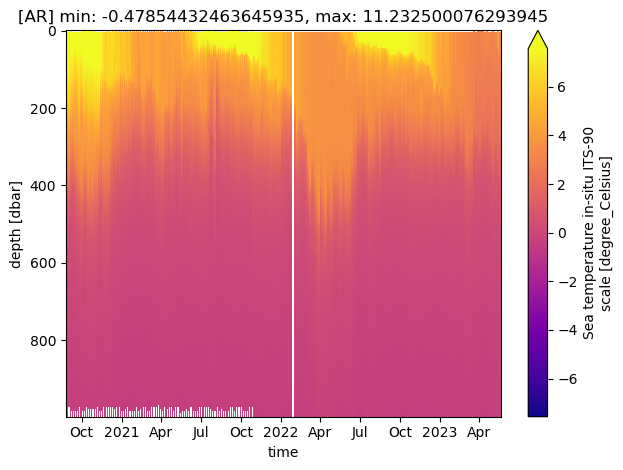

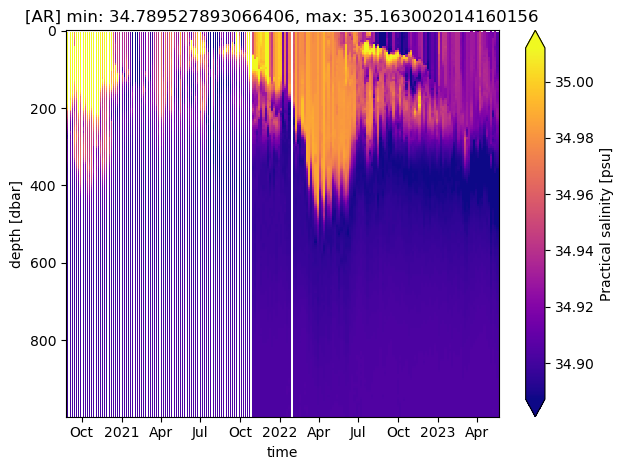

NO GOOD DATA for DOWNWELLING_PAR_ADJUSTED


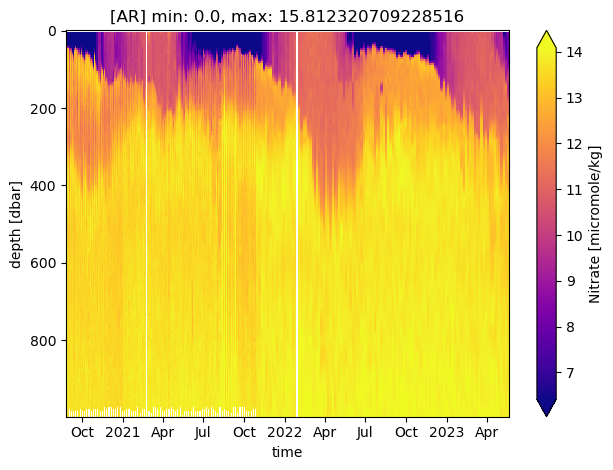

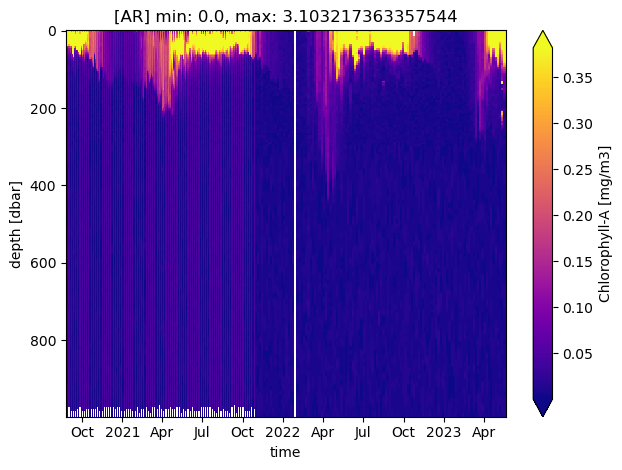

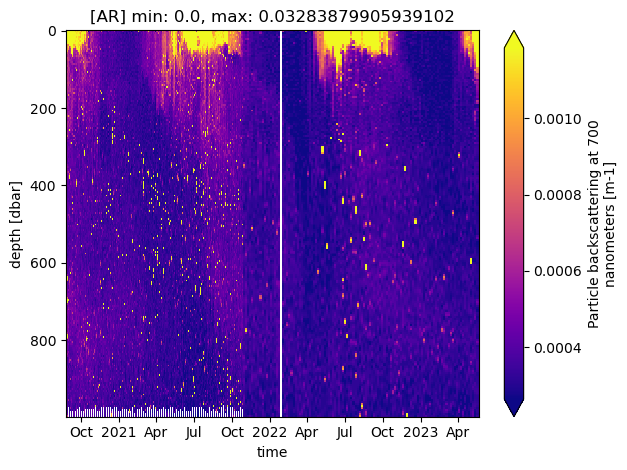

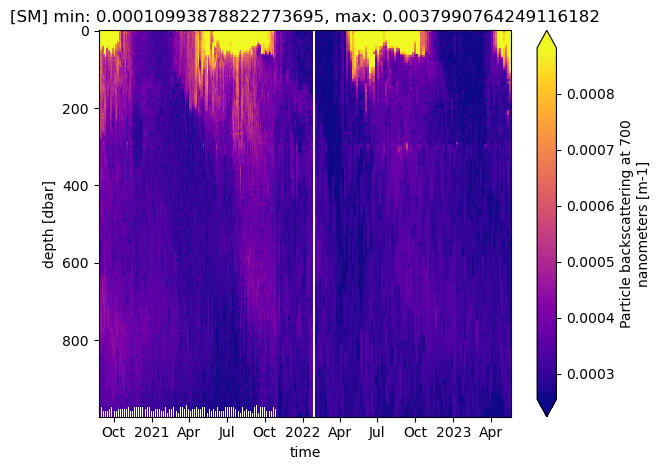

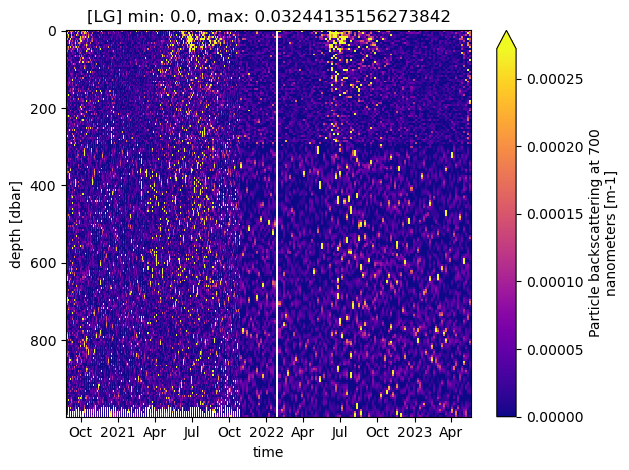

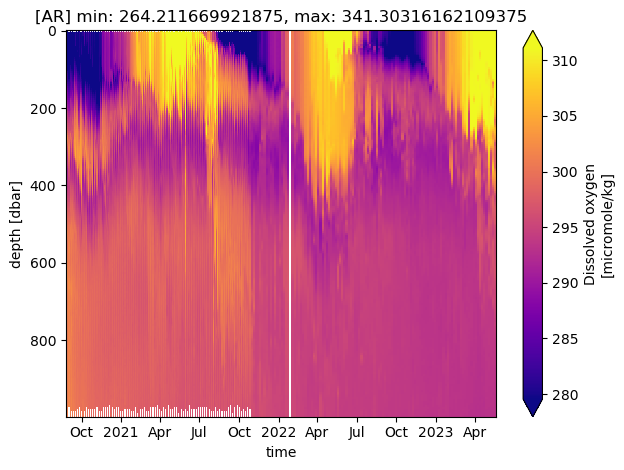

NO GOOD DATA for PH_IN_SITU_TOTAL_ADJUSTED


In [148]:
# Interpolate and create xarray data array
for j in range(len(vars_original)):
    try:
        good_ds,good_pres = ds_valid(vars_original[j],qc2keep)
        if good_ds.notnull().any(): # if finite values exit
            if vars_original[j] == "CHLA_ADJUSTED":
                good_ds = ds_smooth
            elif vars_original[j] == "BBP700_ADJUSTED":
                good_ds = ds_bbp
            data_int = interpolate_argo(good_pres.values,pres_int,good_ds.values)
            ds_int[vars_original[j]+'_AR'] = create_data_array(vars_original[j],data_int,pres_int,ds["JULD"].values)
            # offset by negatives
            if vars_original[j] in ["NITRATE_ADJUSTED", "CHLA_ADJUSTED"]:
                ds_int[vars_original[j]+'_AR'].values = offset_by_neg(ds_int[vars_original[j]+'_AR'])
            # set negatives to zeros
            if vars_original[j] == "BBP700_ADJUSTED":
                ds_int[vars_original[j]+'_AR'].values = set_neg2zero(ds_int[vars_original[j]+'_AR'])
                
            #Visualization
            plt.figure()
            ds_int[vars_original[j]+"_AR"].plot(x="time",robust=True,cmap="plasma")
            mmin,mmax = ds_int[vars_original[j]+"_AR"].min(),ds_int[vars_original[j]+"_AR"].max()
            plt.title("[AR] min: "+str(mmin.values)+", max: "+str(mmax.values))
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            plt.close()            
            
            # add small (SM) and large (LG) fractions of BBP700_ADJUSTED
            if vars_original[j] == "BBP700_ADJUSTED":
                # SMall
                good_ds = ds_bbps
                data_int = interpolate_argo(good_pres.values,pres_int,good_ds.values)
                ds_int["BBP700SM_ADJUSTED_AR"] = create_data_array("BBP700_ADJUSTED",data_int,pres_int,ds["JULD"].values)
                ds_int["BBP700SM_ADJUSTED_AR"].values = set_neg2zero(ds_int["BBP700SM_ADJUSTED_AR"])
                
                # LarGe
                good_ds = ds_bbpl
                data_int = interpolate_argo(good_pres.values,pres_int,good_ds.values)
                ds_int["BBP700LG_ADJUSTED_AR"] = create_data_array("BBP700_ADJUSTED",data_int,pres_int,ds["JULD"].values)
                ds_int["BBP700LG_ADJUSTED_AR"].values = set_neg2zero(ds_int["BBP700LG_ADJUSTED_AR"])

                plt.figure()
                ds_int["BBP700SM_ADJUSTED_AR"].plot(x="time",robust=True,cmap="plasma")
                mmin,mmax = ds_int["BBP700SM_ADJUSTED_AR"].min(),ds_int["BBP700SM_ADJUSTED_AR"].max()
                plt.title("[SM] min: "+str(mmin.values)+", max: "+str(mmax.values))
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.show()
                plt.close()    
                
                plt.figure()
                ds_int["BBP700LG_ADJUSTED_AR"].plot(x="time",robust=True,cmap="plasma")
                mmin,mmax = ds_int["BBP700LG_ADJUSTED_AR"].min(),ds_int["BBP700LG_ADJUSTED_AR"].max()
                plt.title("[LG] min: "+str(mmin.values)+", max: "+str(mmax.values))
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.show()
                plt.close()              
        else:
            print('NO GOOD DATA for '+vars_original[j])
    except KeyError:
        print('NO DATA for '+vars_original[j])

## 6. Apply NPQ correction to CHLA_ADJUSTED based on Xing et al. (2012) and 7. derive additional variables

### Initialize additional variables

In [149]:
# Initialize additional variables as 1D or 2D NaNs

ds_int['MLD'] = xr.DataArray(
    np.full(ds["JULD"].size, np.nan).astype(np.float32),
    coords={'time': ('time', ds["JULD"].values)},
    dims=['time'],
    attrs={
        'long_name': 'Mixed layer depth based on 0.03 kg m-3 density criterion',
        'standard_name': 'mixed_layer_depth',
        'units': 'm',
        'valid_min': np.float32(0.0),
        'valid_max': np.float32(1000.0)
    }
)

ds_int['SIGMA0'] = xr.DataArray(
    np.full((ds["JULD"].size, len(pres_int)), np.nan).astype(np.float32),
    coords={'time': ('time', ds["JULD"].values), 'depth': ('depth', pres_int, {'units': 'dbar'})},
    dims=['time', 'depth'],
    attrs={
        'long_name': 'Potential density anomaly (sigma-0)',
        'standard_name': 'sea_water_sigma_theta',
        'comment': 'Potential density anomaly referenced to 0 dbar. See TEOS-10 for details.',
        'units': 'kg/m^3 - 1000',  # or '1' (dimensionless, but often reported as "kg/m3 - 1000")
        'valid_min': np.float32(20.0),
        'valid_max': np.float32(30.0)
    }
)

ds_int['SPICINESS0'] = xr.DataArray(
    np.full((ds["JULD"].size, len(pres_int)), np.nan).astype(np.float32),
    coords={'time': ('time', ds["JULD"].values), 'depth': ('depth', pres_int, {'units': 'dbar'})},
    dims=['time', 'depth'],
    attrs={
        'long_name': 'Spiciness referenced to a pressure of 0 dbar',
        'standard_name': 'spiciness',
        'comment': 'see spiciness0 in https://teos-10.github.io/GSW-Python/gsw_flat.html',
        'units': 'kg m-3',
        'valid_min': np.float32(-100.0),
        'valid_max': np.float32(100.0)
    }
)

ds_int['O2SOL'] = xr.DataArray(
    np.full((ds["JULD"].size, len(pres_int)), np.nan).astype(np.float32),
    coords={'time': ('time', ds["JULD"].values), 'depth': ('depth', pres_int, {'units': 'dbar'})},
    dims=['time', 'depth'],
    attrs={
        'long_name': 'Oxygen saturation concentration',
        'standard_name': 'moles_of_oxygen_per_unit_mass_in_sea_water',
        'comment': 'see O2sol in https://teos-10.github.io/GSW-Python/gsw_flat.html',
        'units': 'micromole/kg',
        'valid_min': np.float32(-5.0),
        'valid_max': np.float32(600.0)
    }
)

### NPQ correction and derive additional variables

In [150]:
if "CHLA_ADJUSTED_AR" in ds_int.data_vars:
    # Initialize NPQ-corrected CHLA_ADJUSTED
    chla_npq = ds_int['CHLA_ADJUSTED_AR'].copy() # NPQ corrected
else:
    chla_npq = False
    print("NO INTERPORATED DATA available for NPQ correction.")

count_npq = 0 # number of NPQ correction applied here
# MLD calculation
for i in range(ds["JULD"].size): # loop over profiles        
    if np.any(np.isfinite(ds_int['TEMP_ADJUSTED_AR'][i,:])) and np.any(np.isfinite(ds_int['PSAL_ADJUSTED_AR'][i,:])): # if good data exists
        # Absolute Salinity
        SA = gsw.SA_from_SP(ds_int['PSAL_ADJUSTED_AR'][i,:], pres_int, ds_int["LONGITUDE"][i].values, ds_int["LATITUDE"][i].values)        
        # Conservative Temperature
        CT = gsw.CT_from_t(SA, ds_int['TEMP_ADJUSTED_AR'][i,:], pres_int)
        # Saturation oxygen concentration (umol/kg)
        ds_int["O2SOL"][i,:] = gsw.O2sol(SA,CT,pres_int,ds_int["LONGITUDE"][i].values,ds_int["LATITUDE"][i].values)
        # Spiciness referenced to a pressure level of 0 dbar, i.e. at surface (kg/m^3)
        ds_int["SPICINESS0"][i,:] = gsw.spiciness0(SA,CT)
        # Potential Density
        ds_int["SIGMA0"][i,:] = gsw.sigma0(SA, CT)
        # Obtain sigma0 at 10 dbar based on linear interpolation
        sigma0_10 = np.interp(10, pres_int, ds_int["SIGMA0"][i,:])
        for j in range(ds_int["SIGMA0"][i,:].size): # loop over samples
            if ds_int["SIGMA0"][i,:][j] > sigma0_10 + 0.03:
                ds_int["MLD"][i] = pres_int[j]
                idx90 = np.argmin(np.abs(pres_int - 0.9*ds_int["MLD"][i].values)) # depth index closest to mld*0.9
                if "CHLA_ADJUSTED_AR" in ds_int.data_vars:
                    if np.any(np.isfinite(ds_int['CHLA_ADJUSTED_AR'][i, :])) and daytime_valid[i] and not mask_qc5[i]: 
                        chla_npq[i,:idx90+1] = np.nanmax(chla_npq[i,:idx90+1]) # set the upper 90% mld to have uniform chla
                        count_npq += 1 # count the number of corrected profiles
                break # stop at the first occurrence

print('Total number of NPQ-corrected profiles in this step:',count_npq)

Total number of NPQ-corrected profiles in this step: 1


### Visualize additional variables

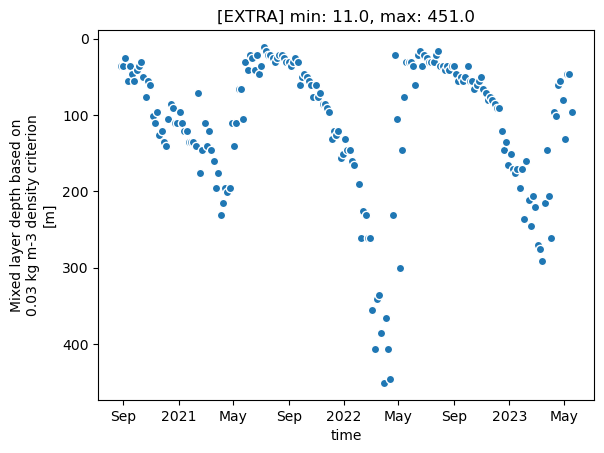

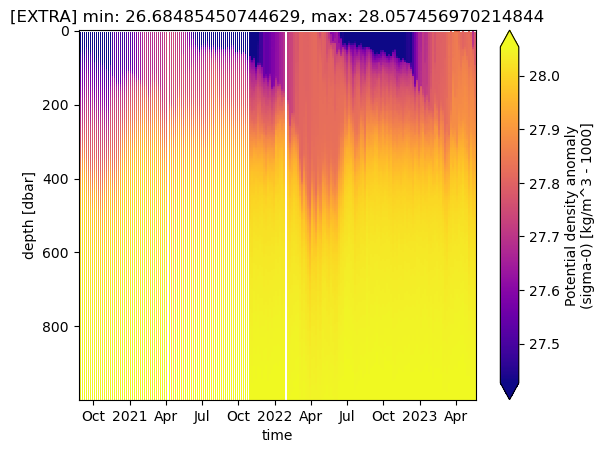

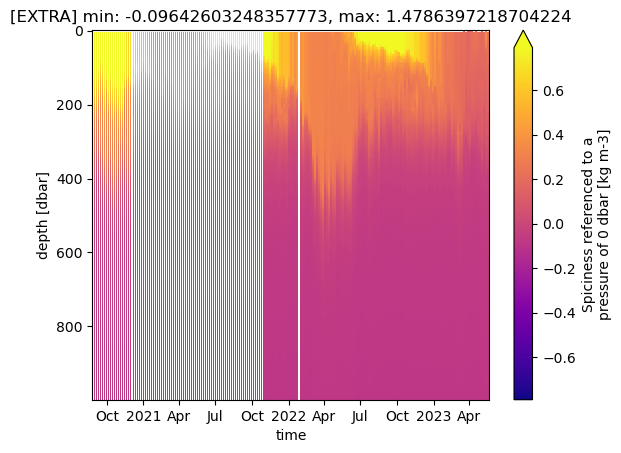

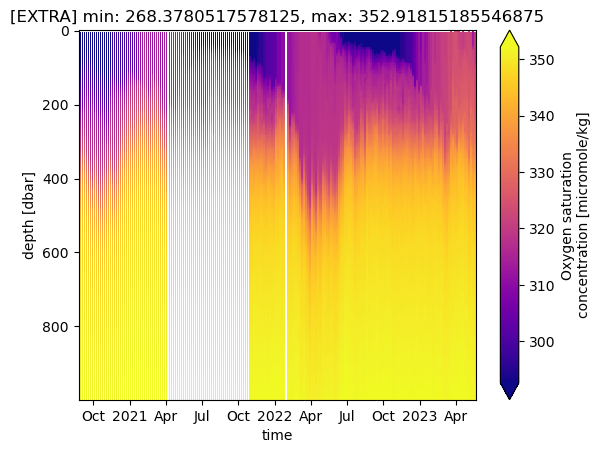

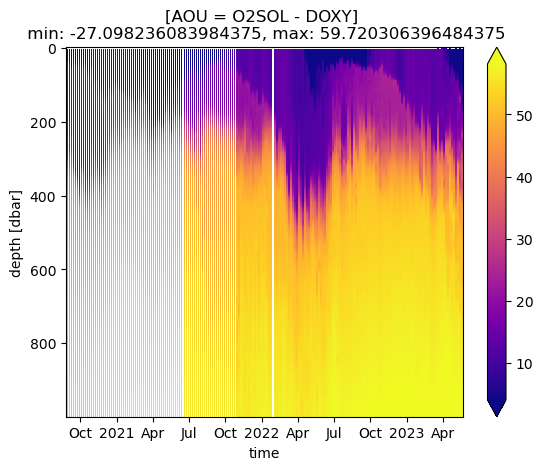

In [151]:
vars_extra = ["MLD","SIGMA0","SPICINESS0","O2SOL"]

for i in range(len(vars_extra)):
    plt.figure()
    mmin,mmax = ds_int[vars_extra[i]].min(),ds_int[vars_extra[i]].max()
    if len(ds_int[vars_extra[i]].shape) == 1:
        ds_int[vars_extra[i]].plot.scatter()
    elif len(ds_int[vars_extra[i]].shape) == 2:
        ds_int[vars_extra[i]].plot(x="time",robust=True,cmap="plasma")
    plt.title("[EXTRA] min: "+str(mmin.values)+", max: "+str(mmax.values))
    plt.gca().invert_yaxis()
    plt.show()
    plt.close()
# In addition, plot AOU: Apparent Oxygen Utilization
if 'DOXY_ADJUSTED_AR' in ds_int.data_vars:
    plt.figure()
    data2plot =  ds_int["O2SOL"]-ds_int['DOXY_ADJUSTED_AR']
    data2plot.plot(x="time",robust=True,cmap="plasma")
    mmin,mmax = data2plot.min(),data2plot.max()    
    plt.title("[AOU = O2SOL - DOXY] \n min: "+str(mmin.values)+", max: "+str(mmax.values))
    plt.gca().invert_yaxis()
    plt.show()
    plt.close()    

### Visualize NPQ correction

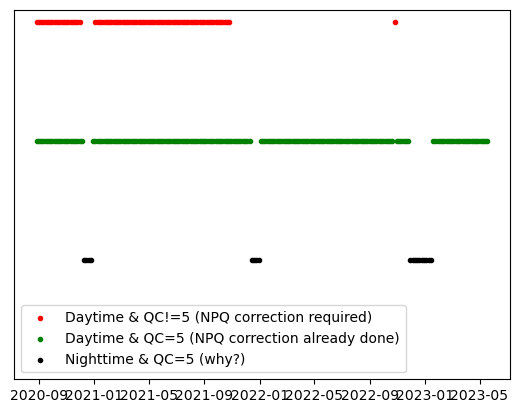

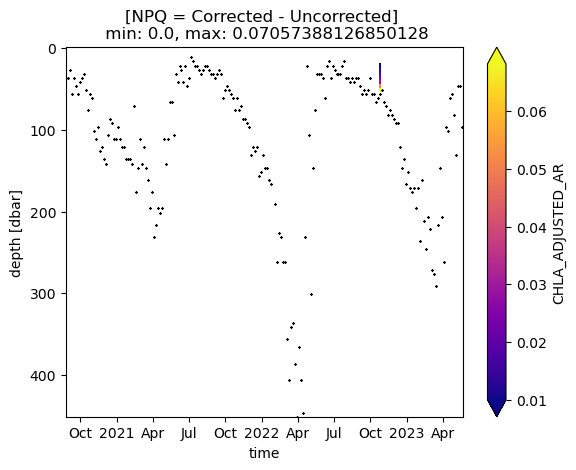

In [152]:
# Daytime vs QC5
if 'CHLA_ADJUSTED_AR' in ds_int.data_vars:
    plt.figure()
    for i in range(ds["JULD"].size):
        # NPQ correction needed
        if not mask_qc5[i] and daytime_valid[i]:
            plt.scatter(ds["JULD"][i],1,marker=".",c="r")
        if mask_qc5[i] and not daytime_valid[i]:
            plt.scatter(ds["JULD"][i],-1,marker=".",c="k")
        if mask_qc5[i] and daytime_valid[i]:    
            plt.scatter(ds["JULD"][i],0,marker=".",c="g")
    plt.scatter([],[],marker=".",c="r",label="Daytime & QC!=5 (NPQ correction required)")
    plt.scatter([],[],marker=".",c="g",label="Daytime & QC=5 (NPQ correction already done)")
    plt.scatter([],[],marker=".",c="k",label="Nighttime & QC=5 (why?)")
    plt.legend(loc="lower left")
    plt.ylim(bottom=-2)
    plt.yticks([]) 
    plt.ylabel(None)    
    plt.show()
    plt.close()

    if count_npq > 0: # visualize if NPQ correction was applied
        plt.figure()
        ds_int["MLD"].plot.scatter(marker="x",zorder=2,s=1,c="k")
        data2plot = chla_npq-ds_int["CHLA_ADJUSTED_AR"]
        data2plot.where(data2plot != 0, other=np.nan).plot(x="time",robust=True,cmap="plasma")
        mmin,mmax = data2plot.min(),data2plot.max()
        plt.title("[NPQ = Corrected - Uncorrected] \n min: "+str(mmin.values)+", max: "+str(mmax.values))
        plt.gca().invert_yaxis()
        plt.ylim(bottom=ds_int["MLD"].max())
        plt.show()
        plt.close()
else:
    print("Nothing to show, as CHLA_ADJUSTED_AR does not exit.")

### Save the analysis-ready output (AR1234567.nc)

In [153]:
# If NPQ correction was done, replace the chlorophyll-a array
if count_npq > 0:
    ds_int['CHLA_ADJUSTED_AR'] = chla_npq

# Add metadata
ds_int.attrs['title'] = 'ar-bgc-argo'
ds_int.attrs['institution'] = 'Japan Agency for Marine-Earth Science and Technology (JAMSTEC)'
ds_int.attrs['notes'] = 'Reference: Fujishima and Hayashida (2026): ar-bgc-argo: Jupyter Notebook templates for searching, downloading, and post-processing biogeochemical Argo float time series, Journal of Open Source Software'
ds_int.attrs['history'] = 'Created on ' + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Save to NetCDF
ds_int.to_netcdf(str(wmoid)+'/AR'+str(wmoid)+'.nc')

ds_int

<xarray.Dataset> Size: 3MB
Dimensions:               (time: 287, depth: 200)
Coordinates:
  * time                  (time) datetime64[ns] 2kB 2020-08-25T22:17:59.99999...
  * depth                 (depth) float64 2kB 1.0 6.0 11.0 ... 986.0 991.0 996.0
Data variables: (12/14)
    LONGITUDE             (time) float32 1kB -0.531 -0.6401 ... -4.414 -4.238
    LATITUDE              (time) float32 1kB 67.5 67.49 67.49 ... 67.34 67.23
    TEMP_ADJUSTED_AR      (time, depth) float32 230kB nan 11.03 ... -0.3298
    PSAL_ADJUSTED_AR      (time, depth) float32 230kB nan nan nan ... 34.9 34.9
    NITRATE_ADJUSTED_AR   (time, depth) float32 230kB nan nan ... 13.93 13.93
    CHLA_ADJUSTED_AR      (time, depth) float32 230kB 1.205 1.238 ... 0.01047
    ...                    ...
    BBP700LG_ADJUSTED_AR  (time, depth) float32 230kB nan nan ... 2.717e-05
    DOXY_ADJUSTED_AR      (time, depth) float32 230kB nan nan ... 293.1 293.1
    MLD                   (time) float32 1kB nan 36.0 nan ... 46.0 46.0 96.0
    SIGMA0                (time, depth) float32 230kB nan nan ... 28.05 28.05
    SPICINESS0            (time, depth) float32 230kB nan nan ... -0.0867
    O2SOL                 (time, depth) float32 230kB nan nan ... 351.5 351.6
Attributes:
    title:        ar-bgc-argo
    institution:  Japan Agency for Marine-Earth Science and Technology (JAMSTEC)
    notes:        Reference: Fujishima and Hayashida (2026): ar-bgc-argo: Jup...
    history:      Created on 2026-01-16-14-33-09